In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 이미지 처리
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# 파일 존재 여부 확인용
import os

In [4]:
# 랜덤숫자 생성
import random

In [5]:
# 클러스터링
from scipy.cluster import hierarchy # hierarchical clustering

In [6]:
# !pip install --upgrade tensorflow==2.13
# !pip install tensorflow==2.15.1

In [7]:
# 모델
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.15.1


# 디렉토리 설정

In [8]:
os.chdir('/content/drive/MyDrive/[perst]데이터셋/MachineLearningProject/02_Fashion Type Classification Model')

In [9]:
train_dir_name = "./Dataset/Musinsa_Dataset/Train-Test_0617/Male/Train/"
model_dir_name = './Model/'

img_width = 200
img_height = 200

# 색상을 추출할 이미지 불러오기

In [ ]:
# print(len(os.listdir(train_dir_name + "Image")))
# 14770

In [10]:
img_list = []

while len(img_list)<10:
  # Train 데이터의 1~14770 파일 랜덤으로 불러오기
  rand_num = random.randint(1, 14770)

  img_path = train_dir_name + "Image/" + str(rand_num) + ".jpg"

  if not os.path.isfile(img_path):
    continue

  # 이미지 파일 로드
  img_file = cv2.imread(img_path)
  if img_file is None:
    print(str(rand_num) + ".jpg File Load Failed!!")
    break

  # 이미지 파일의 색상값을 RGB 형식으로 변경
  img_file = cv2.cvtColor(img_file, cv2.COLOR_BGR2RGB)

  img_list.append(img_file)
  print(len(img_list))

print("Complete")

1
2
3
4
5
6
7
8
9
10
Complete


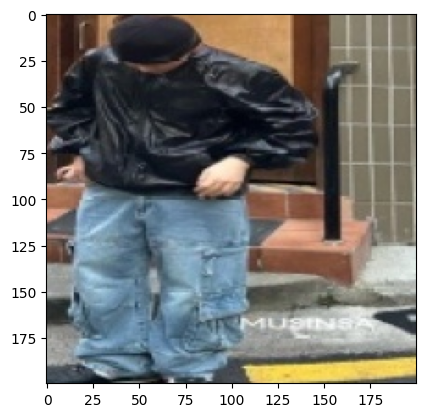

In [11]:
plt.imshow(img_list[0])
plt.show()

# 학습을 위해 X 데이터 형식 변경

In [12]:
img_list = np.array(img_list)
img_list.shape

(10, 200, 200, 3)

# 이미지 배경 제거

## 마스크 생성

In [13]:
# 모델 불러오기
seg_model_path = model_dir_name + "poly_seg_model_0428_02.keras"

seg_model = keras.models.load_model(seg_model_path)
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 200, 200, 64)         4864      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 200, 200, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 200, 200, 64)         36928     ['dropout[0][0]']             
                                                                                              

In [14]:
# 데이터 크기 확인
print(img_list.shape)

print("Complete")

(10, 200, 200, 3)
Complete


In [15]:
# 예측 진행
seg_preds = seg_model.predict(img_list)
print("Complete")

1/1 [==============================] - 2s 2s/step
Complete


In [16]:
# 예측 결과를 마스크로 생성하고 저장

mask_list = []

for i in range(0, len(seg_preds)):
    total_mask = seg_preds[i].argmax(axis=-1)
    bg_mask = np.ones(total_mask.shape, dtype=np.uint8)
    bg_mask[total_mask == 0] = 0
    mask_list.append(bg_mask)

print("Complete")

Complete


In [17]:
data_list = []

for i in range(0, len(img_list)):
  data_list.append([img_list[i], mask_list[i]])

print("Complete")

Complete


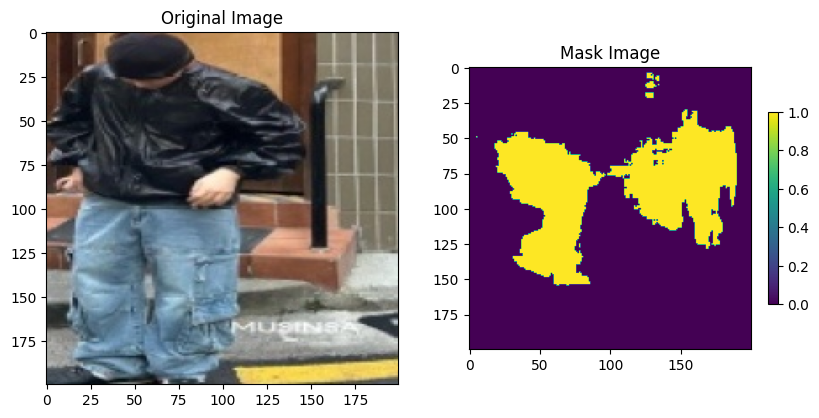

In [18]:
# 마스크 형태 확인
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(data_list[0][0])
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(data_list[0][1])
plt.clim(0, 1)
plt.colorbar(shrink=0.5)
plt.title("Mask Image")

plt.show()

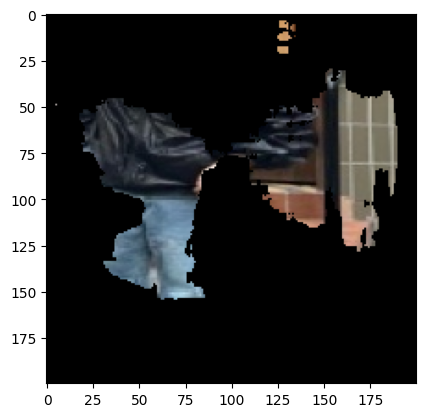

In [19]:
# 마스크를 원본 이미지에 적용
masked_sample = cv2.bitwise_and(data_list[0][0], data_list[0][0], mask=data_list[0][1])

plt.imshow(masked_sample)
plt.show()

0번째 이미지


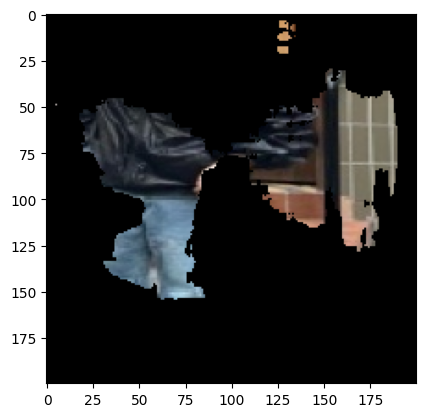

1번째 이미지


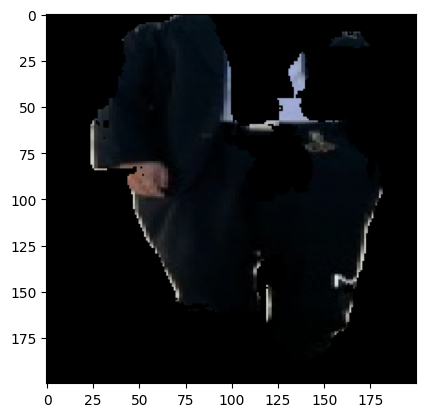

2번째 이미지


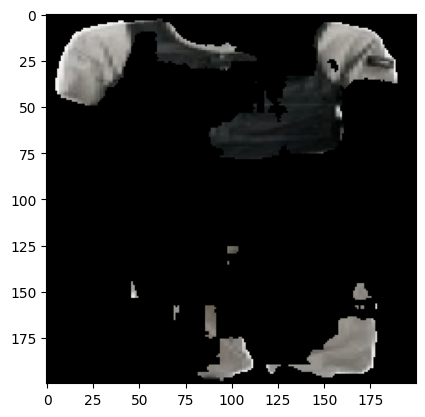

3번째 이미지


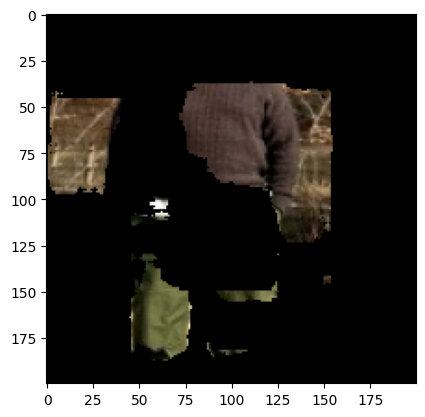

4번째 이미지


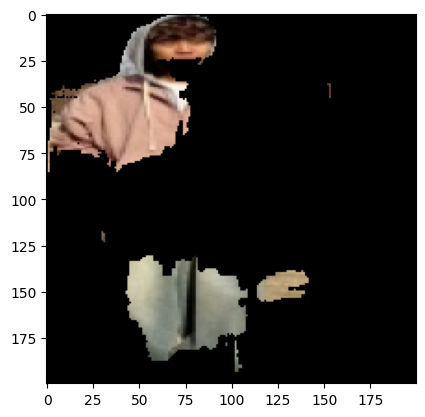

5번째 이미지


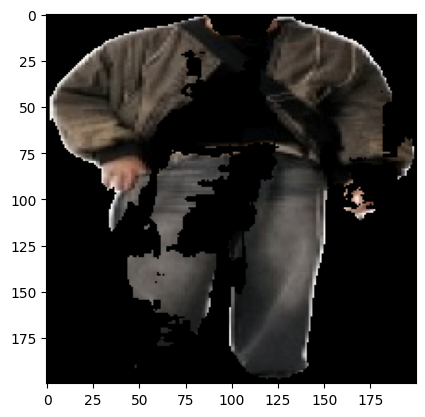

6번째 이미지


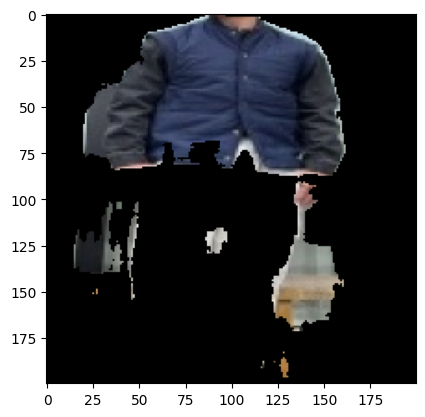

7번째 이미지


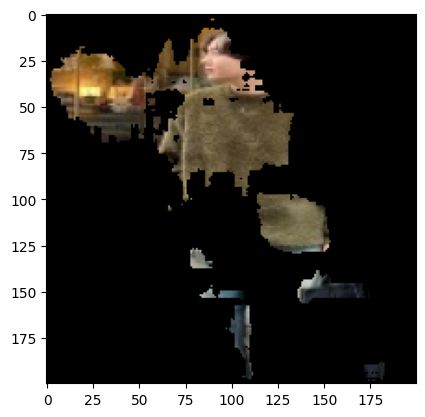

8번째 이미지


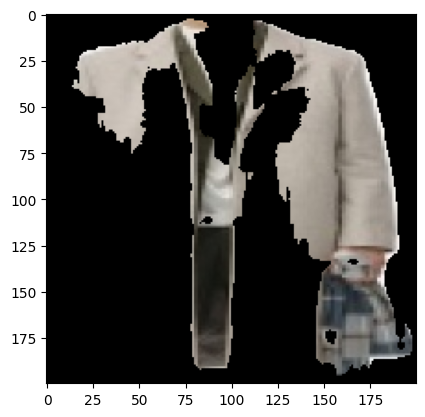

9번째 이미지


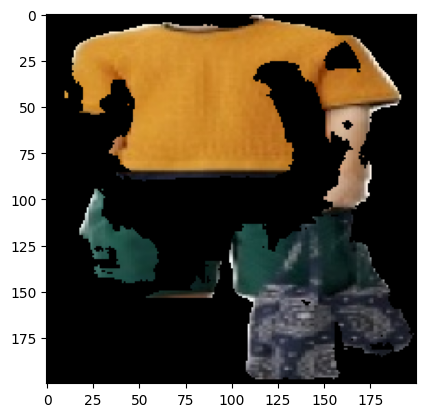

In [23]:
# 전체 이미지를 출력하여 샘플로 사용할 이미지 선택
for i in range(0, len(data_list)):
  masked_sample = cv2.bitwise_and(data_list[i][0], data_list[i][0], mask=data_list[i][1])
  print(str(i) + "번째 이미지")
  plt.imshow(masked_sample)
  plt.show()

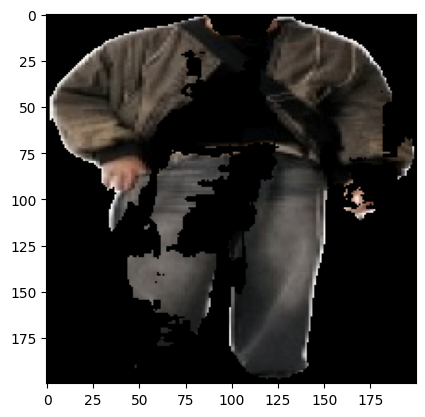

In [24]:
sample_num = 5

sample_img = data_list[sample_num][0]
sample_mask = data_list[sample_num][1]
sample_mask_img = cv2.bitwise_and(sample_img, sample_img, mask=sample_mask)

plt.imshow(sample_mask_img)
plt.show()

# 마스크 영역의 픽셀 색상값 추출

In [25]:
pixel_list = []

for he in range(0, img_height):
  for wi in range(0, img_width):
    if sample_mask[he][wi] == 1:
      r = sample_img[he][wi][0]
      g = sample_img[he][wi][1]
      b = sample_img[he][wi][2]
      pixel_list.append([r, g, b])

pixel_list = np.array(pixel_list)
print("Complete")

Complete


In [26]:
pixel_list.shape

(17495, 3)

# Hierarchical Clustering을 이용하여 색상 군집화

In [27]:
cluster = hierarchy.linkage(pixel_list, method='centroid', metric='euclidean')
predict = hierarchy.fcluster(cluster, 70, criterion='distance') # 거리 70까지 cluster 개수 정하기

print("Complete")

Complete


In [28]:
type(predict)

numpy.ndarray

In [29]:
predict.shape

(17495,)

In [30]:
np.unique(predict, return_counts=True)

(array([1, 2, 3, 4], dtype=int32), array([  325,   329,  5277, 11564]))

In [31]:
len(np.unique(predict))

4

# 각 군집별로 평균 색상 계산

In [32]:
cluster_pixel = []
for i in range(0, len(np.unique(predict))):
  cluster_pixel.append([])

for i in range(0, len(predict)):
  cluster_pixel[predict[i]-1].append(pixel_list[i])

for i in range(0, len(cluster_pixel)):
  cluster_pixel[i] = np.array(cluster_pixel[i])

for i in range(0, len(cluster_pixel)):
  cluster_pixel[i] = np.mean(cluster_pixel[i], axis=0)
  cluster_pixel[i] = cluster_pixel[i].astype(int)

print("Complete")

Complete


In [33]:
for i in range(0, len(cluster_pixel)):
  print(cluster_pixel[i])

[234 228 224]
[184 174 169]
[107  98  90]
[46 43 39]


# 군집화 결과 색상 시각화

## 각 군집을 빈도수에 따라 정렬

In [34]:
label, count = np.unique(predict, return_counts=True)
print(label)
print(count)

[1 2 3 4]
[  325   329  5277 11564]


In [35]:
count_dict = {}

for i in range(0, len(label)):
  count_dict[label[i]] = count[i]

print(count_dict)

{1: 325, 2: 329, 3: 5277, 4: 11564}


In [36]:
sorted_count = sorted(count_dict.items(), key= lambda item:item[1], reverse=True)
print(sorted_count)

[(4, 11564), (3, 5277), (2, 329), (1, 325)]


In [37]:
label = []
count = []

for item in sorted_count:
    label.append(item[0])
    count.append(item[1])

print(label)
print(count)

[4, 3, 2, 1]
[11564, 5277, 329, 325]


In [38]:
total = np.sum(count)
ratio = []

for i in range(0, len(count)):
    ra = (count[i]/total) * 100

    ratio_string = (' %.1f%%' % ra)
    ratio.append(ratio_string)

print(ratio)

[' 66.1%', ' 30.2%', ' 1.9%', ' 1.9%']


## 군집별 색상 및 빈도 시각화

In [39]:
for i in range(0, len(cluster_pixel)):
  print(str(i+1) + ' ' + str(cluster_pixel[i]))

1 [234 228 224]
2 [184 174 169]
3 [107  98  90]
4 [46 43 39]


In [40]:
for i in range(0, len(label)):
  print(str(label[i]) + ' ' + str(cluster_pixel[label[i]-1]) + ' ' +  str(count[i]) + ' ' + str(ratio[i]))

4 [46 43 39] 11564  66.1%
3 [107  98  90] 5277  30.2%
2 [184 174 169] 329  1.9%
1 [234 228 224] 325  1.9%


In [41]:
color_view = []

for i in range(0, len(cluster_pixel)):
  view = np.full((10, 10, 3), cluster_pixel[i], dtype=np.uint8)
  color_view.append(view)

print("Complete")

Complete


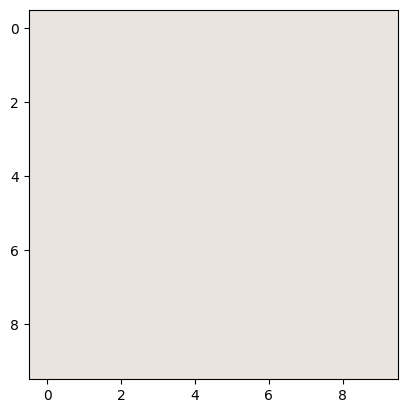

In [42]:
plt.imshow(color_view[0])
plt.show()

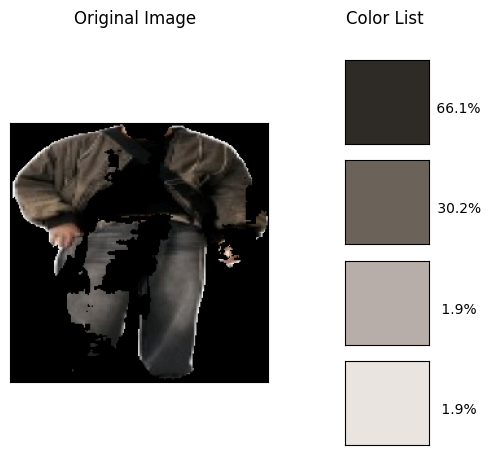

In [43]:
fig = plt.figure(figsize=(5, 5))
subplots = fig.subfigures(1, 2, width_ratios=[2, 1], wspace=0.0)

ax1 = subplots[0].subplots(1, 1)
ax2 = subplots[1].subplots(len(label), 1)
subplots[0].suptitle('Original Image')
subplots[1].suptitle('Color List')

ax1.imshow(sample_mask_img)
ax1.set_xticks([])
ax1.set_yticks([])

for i in range(0, len(label)):
  ax2[i].imshow(color_view[label[i]-1])
  ax2[i].set_xticks([])
  ax2[i].set_yticks([])
  ax2[i].yaxis.set_label_position('right')
  ax2[i].set_ylabel(str(ratio[i]), rotation=0, labelpad=20, loc='center')


plt.show()

# 10개 이미지에 전부 색상 군집화 적용하기

In [44]:
# 마스크 영역의 픽셀값 추출
total_pixel_list = []

for i in range(0, len(data_list)):
  pixel_list = []

  for he in range(0, img_height):
    for wi in range(0, img_width):
      if data_list[i][1][he][wi] == 1:
        r = data_list[i][0][he][wi][0]
        g = data_list[i][0][he][wi][1]
        b = data_list[i][0][he][wi][2]
        pixel_list.append([r, g, b])

  pixel_list = np.array(pixel_list)
  total_pixel_list.append(pixel_list)

print("Complete")

Complete


In [45]:
# 클러스터링
total_predict = []

for i in range(0, len(data_list)):
  print(str(i+1) + "번째 이미지 색상 클러스터링중...")
  cluster = hierarchy.linkage(total_pixel_list[i], method='centroid', metric='euclidean')
  predict = hierarchy.fcluster(cluster, 70, criterion='distance') # 거리 70까지 cluster 개수 정하기
  total_predict.append(predict)

print("Complete")

1번째 이미지 색상 클러스터링중...
2번째 이미지 색상 클러스터링중...
3번째 이미지 색상 클러스터링중...
4번째 이미지 색상 클러스터링중...
5번째 이미지 색상 클러스터링중...
6번째 이미지 색상 클러스터링중...
7번째 이미지 색상 클러스터링중...
8번째 이미지 색상 클러스터링중...
9번째 이미지 색상 클러스터링중...
10번째 이미지 색상 클러스터링중...
Complete


In [46]:
# 각 군집별 평균 색상 계산
total_cluster_pixel = []

for x in range(0, len(data_list)):
  cluster_pixel = []
  for i in range(0, len(np.unique(total_predict[x]))):
    cluster_pixel.append([])

  for i in range(0, len(total_predict[x])):
    cluster_pixel[total_predict[x][i]-1].append(total_pixel_list[x][i])

  for i in range(0, len(cluster_pixel)):
    cluster_pixel[i] = np.array(cluster_pixel[i])

  for i in range(0, len(cluster_pixel)):
    cluster_pixel[i] = np.mean(cluster_pixel[i], axis=0)
    cluster_pixel[i] = cluster_pixel[i].astype(int)

  total_cluster_pixel.append(cluster_pixel)

print("Complete")

Complete


In [47]:
# 라벨명과 색상을 빈도순으로 정렬하고 백분율 정보 추가
total_label = []
total_count = []
total_ratio = []

for x in range(0, len(data_list)):
  # 라벨명과 카운트 정보 추출
  label, count = np.unique(total_predict[x], return_counts=True)

  # 라벨명과 카운트를 딕셔너리화
  count_dict = {}
  for i in range(0, len(label)):
    count_dict[label[i]] = count[i]

  # 딕셔너리 정렬
  sorted_count = sorted(count_dict.items(), key= lambda item:item[1], reverse=True)

  # 정렬된 순서대로 다시 리스트에 저장
  label = []
  count = []
  for item in sorted_count:
    label.append(item[0])
    count.append(item[1])

  # 백분율 계산
  total = np.sum(count)
  ratio = []

  for i in range(0, len(count)):
      ra = (count[i]/total) * 100

      ratio_string = (' %.1f%%' % ra)
      ratio.append(ratio_string)

  # 전체 리스트에 저장
  total_label.append(label)
  total_count.append(count)
  total_ratio.append(ratio)

  # 진행도 확인용
  print(str(x+1) + "번째 이미지 픽셀 정보 계산 완료")

print("Complete")

1번째 이미지 픽셀 정보 계산 완료
2번째 이미지 픽셀 정보 계산 완료
3번째 이미지 픽셀 정보 계산 완료
4번째 이미지 픽셀 정보 계산 완료
5번째 이미지 픽셀 정보 계산 완료
6번째 이미지 픽셀 정보 계산 완료
7번째 이미지 픽셀 정보 계산 완료
8번째 이미지 픽셀 정보 계산 완료
9번째 이미지 픽셀 정보 계산 완료
10번째 이미지 픽셀 정보 계산 완료
Complete


In [48]:
# 각 군집의 평균색상 이미지 생성
total_color_view = []

for x in range(0, len(data_list)):
  color_view = []

  for i in range(0, len(total_cluster_pixel[x])):
    view = np.full((10, 10, 3), total_cluster_pixel[x][i], dtype=np.uint8)
    color_view.append(view)
  total_color_view.append(color_view)

print("Complete")

Complete


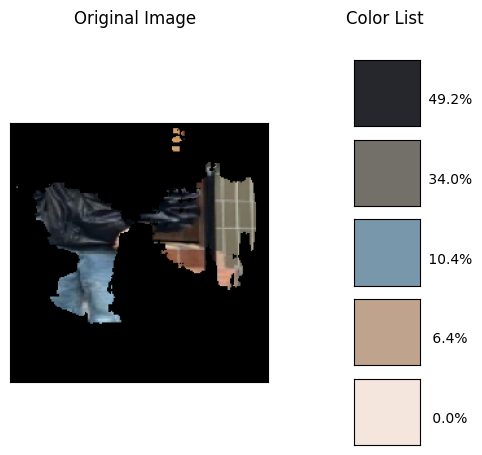

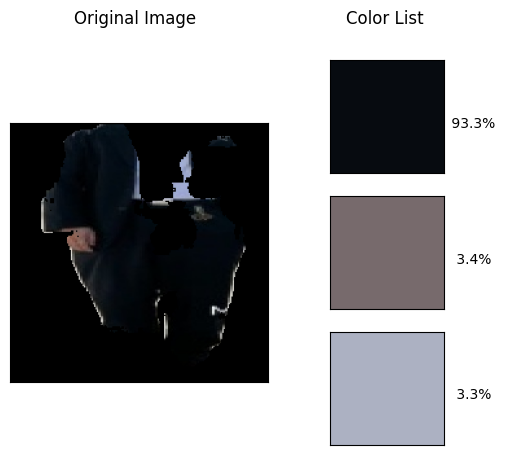

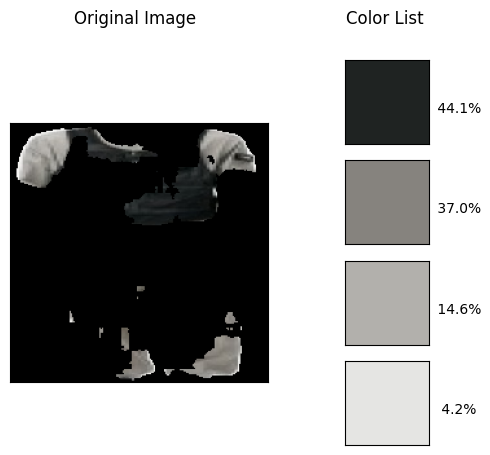

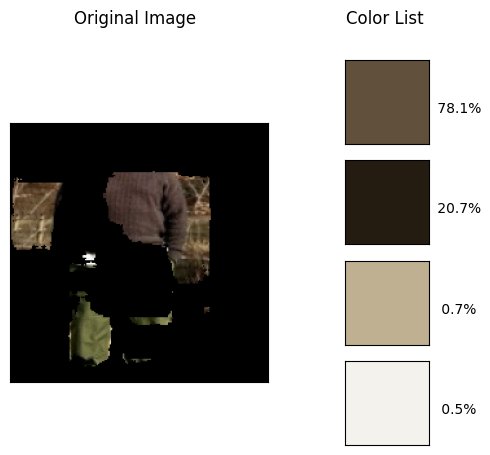

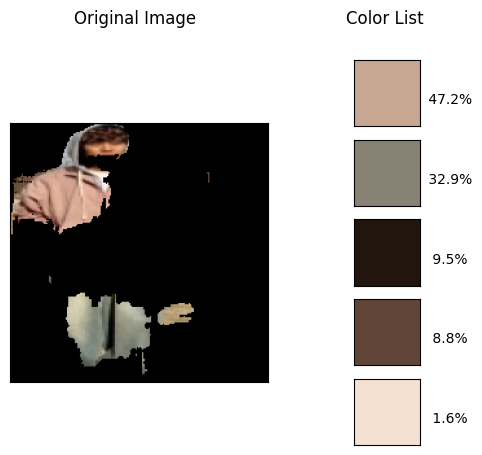

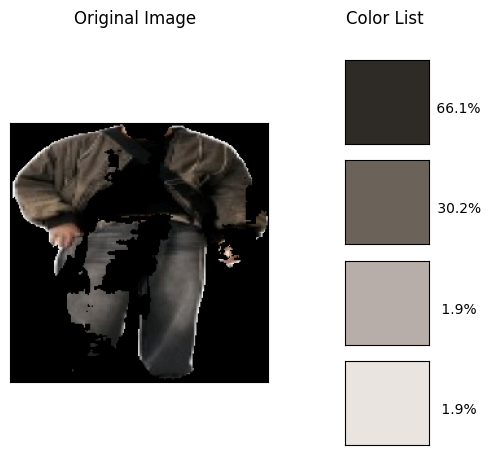

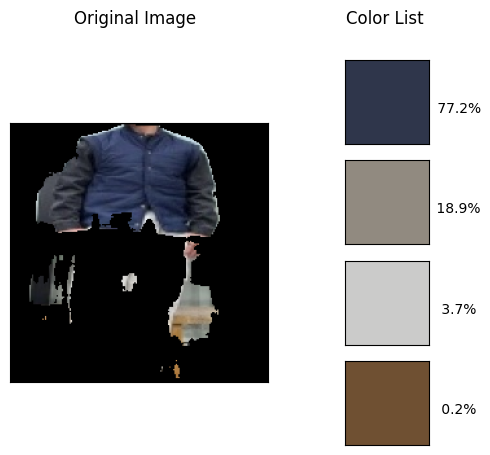

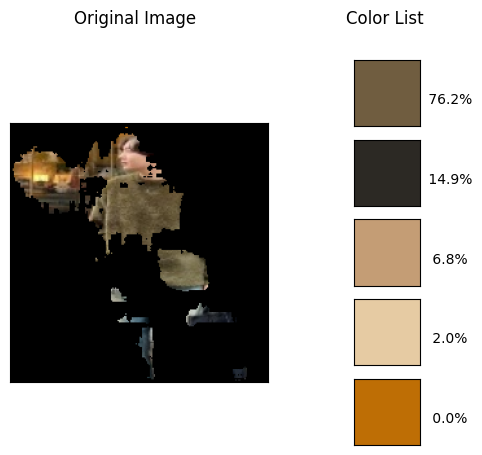

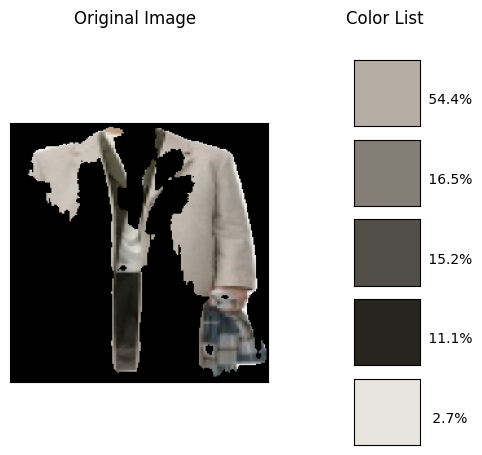

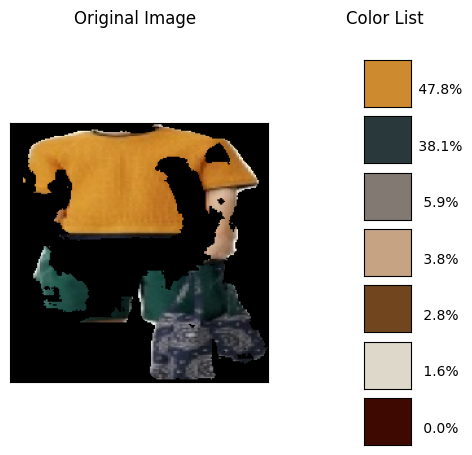

In [49]:
# 그래프 시각화
for x in range(0, len(data_list)):
  fig = plt.figure(figsize=(5, 5))
  subplots = fig.subfigures(1, 2, width_ratios=[2, 1], wspace=0.0)

  ax1 = subplots[0].subplots(1, 1)
  ax2 = subplots[1].subplots(len(total_label[x]), 1)
  subplots[0].suptitle('Original Image')
  subplots[1].suptitle('Color List')

  # 마스크 적용된 원본 이미지 출력
  masked_img = cv2.bitwise_and(data_list[x][0], data_list[x][0], mask=data_list[x][1])
  ax1.imshow(masked_img)
  ax1.set_xticks([])
  ax1.set_yticks([])

  # 각 군집별 색상과 비율 출력
  for i in range(0, len(total_label[x])):
    ax2[i].imshow(total_color_view[x][(total_label[x][i])-1])
    ax2[i].set_xticks([])
    ax2[i].set_yticks([])
    ax2[i].yaxis.set_label_position('right')
    ax2[i].set_ylabel(str(total_ratio[x][i]), rotation=0, labelpad=20, loc='center')


plt.show()